## Daniel Rivera | MAE 598: Design Optimization | HW 3
## Prof. Max Yi Ren | Fall 2022



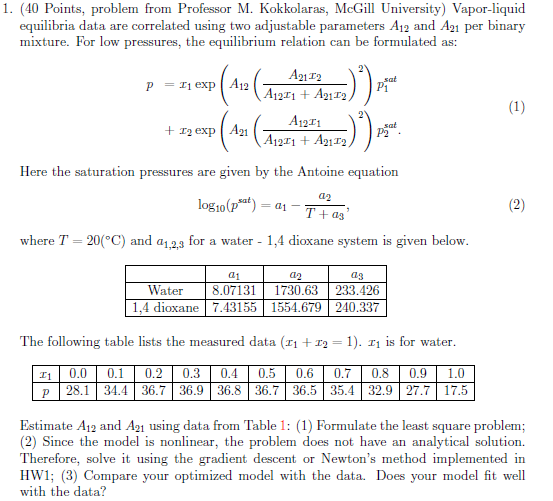

In [1]:
#Import all of the necessary libraries
import torch 
import numpy as np
from torch.autograd import Variable
import matplotlib.pyplot as plt
from IPython import display

#Define our measured data X1 and X2

X1 = np.array([[0.0, 0.1, 0.2, 0.3, 0.4, 0.5 ,0.6, 0.7, 0.8, 0.9, 1.0]])
#Since x1+x2=1, we can flip x1 and equate this to x2
X2 = np.flip(X1, axis=1).copy()

#Define our a as an array

a = np.array(([[8.07131, 1730.63, 233.426], [7.43155, 1554.679, 240.337]]))
T= 20
p_water = 10 ** (a[0, 0] - a[0, 1] / (T + a[0, 2]))
p_dio = 10 ** (a[1, 0] - a[1, 1] / (T + a[1, 2]))
P = np.array([[28.1, 34.4, 36.7, 36.9, 36.8, 36.7, 36.5, 35.4, 32.9, 27.7, 17.5]])
P = torch.tensor(P, requires_grad=False, dtype=torch.float32)

A = Variable(torch.tensor([1.0, 1.0]), requires_grad=True)

#Specify two tensors 

x1 = torch.tensor(X1, requires_grad=False, dtype=torch.float32)
x2 = torch.tensor(X2, requires_grad=False, dtype=torch.float32)

a = 0.0001
#itereate using for loop and define p_predicion as defined in the problem statement
for i in range(100):
    P_pred = x1 * torch.exp(A[0] * (A[1] * x2 / (A[0] * x1 + A[1] * x2)) ** 2) * p_water + \
        x2 * torch.exp(A[1] * (A[0] * x1 / (A[0] * x1 + A[1] * x2)) ** 2) * p_dio
#Specify our loss term and take the sum of all loss values throughout every iteration
    loss = (P_pred - P) ** 2
    loss = loss.sum()

    loss.backward()
#Take the gradient of this function and print the estimations of A12 and A21 and the summation of loss
    with torch.no_grad():
        A -= a * A.grad

        A.grad.zero_()

print('estimation A12 and A21 is:',A)
print('final loss is:',loss.data.numpy())

estimation A12 and A21 is: tensor([1.9110, 1.7293], requires_grad=True)
final loss is: 0.8783658


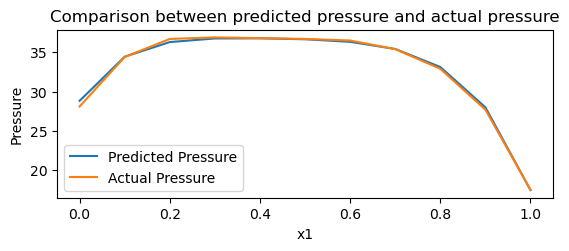

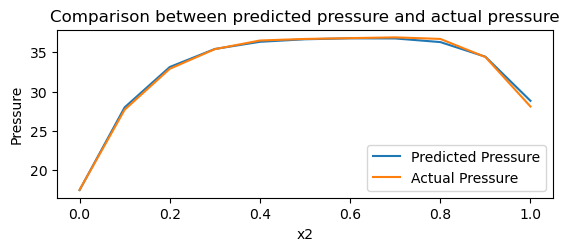

In [2]:
import matplotlib.pyplot as plt
P_pred = P_pred.detach().numpy()[0]
P = P.detach().numpy()[0]
x1 = x1.detach().numpy()[0]
x2= x2.detach().numpy()[0]
plt.subplot(211)
plt.plot(x1, P_pred, label='Predicted Pressure')
plt.plot(x1, P, label='Actual Pressure')
plt.xlabel('x1')
plt.ylabel('Pressure')
plt.legend()
plt.title('Comparison between predicted pressure and actual pressure')
plt.show()

plt.subplot(212)
plt.plot(x2, P_pred, label='Predicted Pressure')
plt.plot(x2, P, label='Actual Pressure')
plt.xlabel('x2')
plt.ylabel('Pressure')
plt.legend()
plt.title('Comparison between predicted pressure and actual pressure')
plt.show()

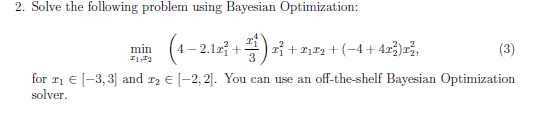

In [1]:
#Bayesian Optimization Function 
#import necessary libraries 
import numpy as np
import sklearn.gaussian_process as gp

from scipy.stats import norm
from scipy.optimize import minimize

def expected_improvement(x, gaussian_process, evaluated_loss, greater_is_better=False, n_params=1):
    """ expected_improvement

    Expected improvement acquisition function.

    Arguments:
    ----------
        x: array-like, shape = [n_samples, n_hyperparams]
            The point for which the expected improvement needs to be computed.
        gaussian_process: GaussianProcessRegressor object.
            Gaussian process trained on previously evaluated hyperparameters.
        evaluated_loss: Numpy array.
            Numpy array that contains the values off the loss function for the previously
            evaluated hyperparameters.
        greater_is_better: Boolean.
            Boolean flag that indicates whether the loss function is to be maximised or minimised.
        n_params: int.
            Dimension of the hyperparameter space.

    """

    x_to_predict = x.reshape(-1, n_params)

    mu, sigma = gaussian_process.predict(x_to_predict, return_std=True)

    if greater_is_better:
        loss_optimum = np.max(evaluated_loss)
    else:
        loss_optimum = np.min(evaluated_loss)

    scaling_factor = (-1) ** (not greater_is_better)

    # In case sigma equals zero
    with np.errstate(divide='ignore'):
        Z = scaling_factor * (mu - loss_optimum) / sigma
        expected_improvement = scaling_factor * (mu - loss_optimum) * norm.cdf(Z) + sigma * norm.pdf(Z)
        expected_improvement[sigma == 0.0] == 0.0

    return -1 * expected_improvement


def sample_next_hyperparameter(acquisition_func, gaussian_process, evaluated_loss, greater_is_better=False,
                               bounds=(0, 10), n_restarts=25):
    """ sample_next_hyperparameter

    Proposes the next hyperparameter to sample the loss function for.

    Arguments:
    ----------
        acquisition_func: function.
            Acquisition function to optimise.
        gaussian_process: GaussianProcessRegressor object.
            Gaussian process trained on previously evaluated hyperparameters.
        evaluated_loss: array-like, shape = [n_obs,]
            Numpy array that contains the values off the loss function for the previously
            evaluated hyperparameters.
        greater_is_better: Boolean.
            Boolean flag that indicates whether the loss function is to be maximised or minimised.
        bounds: Tuple.
            Bounds for the L-BFGS optimiser.
        n_restarts: integer.
            Number of times to run the minimiser with different starting points.

    """
    best_x = None
    best_acquisition_value = 1
    n_params = bounds.shape[0]

    for starting_point in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, n_params)):

        res = minimize(fun=acquisition_func,
                       x0=starting_point.reshape(1, -1),
                       bounds=bounds,
                       method='L-BFGS-B',
                       args=(gaussian_process, evaluated_loss, greater_is_better, n_params))

        if res.fun < best_acquisition_value:
            best_acquisition_value = res.fun
            best_x = res.x

    return best_x


def bayesian_optimisation(n_iters, sample_loss, bounds, x0=None, n_pre_samples=5,
                          gp_params=None, random_search=False, alpha=1e-5, epsilon=1e-7):
    """ bayesian_optimisation

    Uses Gaussian Processes to optimise the loss function `sample_loss`.

    Arguments:
    ----------
        n_iters: integer.
            Number of iterations to run the search algorithm.
        sample_loss: function.
            Function to be optimised.
        bounds: array-like, shape = [n_params, 2].
            Lower and upper bounds on the parameters of the function `sample_loss`.
        x0: array-like, shape = [n_pre_samples, n_params].
            Array of initial points to sample the loss function for. If None, randomly
            samples from the loss function.
        n_pre_samples: integer.
            If x0 is None, samples `n_pre_samples` initial points from the loss function.
        gp_params: dictionary.
            Dictionary of parameters to pass on to the underlying Gaussian Process.
        random_search: integer.
            Flag that indicates whether to perform random search or L-BFGS-B optimisation
            over the acquisition function.
        alpha: double.
            Variance of the error term of the GP.
        epsilon: double.
            Precision tolerance for floats.
    """

    x_list = []
    y_list = []

    n_params = bounds.shape[0]

    if x0 is None:
        for params in np.random.uniform(bounds[:, 0], bounds[:, 1], (n_pre_samples, bounds.shape[0])):
            x_list.append(params)
            y_list.append(sample_loss(params))
            # print()
    else:
        for params in x0:
            x_list.append(params)
            y_list.append(sample_loss(params))

    xp = np.array(x_list)
    yp = np.array(y_list)

    # Create the GP
    if gp_params is not None:
        model = gp.GaussianProcessRegressor(**gp_params)
    else:
        kernel = gp.kernels.Matern()
        model = gp.GaussianProcessRegressor(kernel=kernel,
                                            alpha=alpha,
                                            n_restarts_optimizer=10,
                                            normalize_y=True)

    for n in range(n_iters):

        model.fit(xp, yp)

        # Sample next hyperparameter
        if random_search:
            x_random = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(random_search, n_params))
            ei = -1 * expected_improvement(x_random, model, yp, greater_is_better=True, n_params=n_params)
            next_sample = x_random[np.argmax(ei), :]
        else:
            next_sample = sample_next_hyperparameter(expected_improvement, model, yp, greater_is_better=True, bounds=bounds, n_restarts=100)

        # Duplicates will break the GP. In case of a duplicate, we will randomly sample a next query point.
        if np.any(np.abs(next_sample - xp) <= epsilon):
            next_sample = np.random.uniform(bounds[:, 0], bounds[:, 1], bounds.shape[0])

        # Sample loss for new set of parameters
        cv_score = sample_loss(next_sample)

        # Update lists
        x_list.append(next_sample)
        y_list.append(cv_score)

        # Update xp and yp
        xp = np.array(x_list)
        yp = np.array(y_list)

    return xp, yp

def sample_loss(params):
    """
    objective function definition
    """
    return (4 - 2.1 * params[0] ** 2 + params[0] ** 4 / 3) * params[0] ** 2 + params[0] * params[1] + (-4 + 4 * params[1] ** 2) * params[1] ** 2

bounds = np.array([[-3, 3], [-2, 2]])

xp, yp = bayesian_optimisation(n_iters=30,
                               sample_loss=sample_loss,
                               bounds=bounds,
                               n_pre_samples=20,
                               random_search=100000)

print('minimum objective function:', np.min(yp))
print('x1, x2 when having minumum objective function:',xp[np.argmin(yp)])
print('solution x1, x2:', xp)
print('objective function:', yp)

C:\Users\daniel.rivera\anaconda3\envs\Design_Optimization_Scripts\lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\daniel.rivera\anaconda3\envs\Design_Optimization_Scripts\lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\daniel.rivera\anaconda3\envs\Design_Optimization_Scripts\lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.



minimum objective function: -0.029100596332612777
x1, x2 when having minumum objective function: [ 0.28647987 -0.26799298]
solution x1, x2: [[-2.41880513e+00 -1.58281648e+00]
 [ 1.81813678e+00  1.38374924e+00]
 [ 1.31311555e+00  1.90458007e+00]
 [-2.95069156e+00 -2.11394961e-03]
 [ 2.84131174e+00 -7.89720537e-02]
 [-2.47959540e+00 -1.44596162e+00]
 [-1.98165535e+00 -4.42181209e-01]
 [-1.93943641e+00 -6.06219644e-02]
 [-1.89979337e+00  4.19844303e-02]
 [ 1.53131132e+00  1.68762391e+00]
 [ 2.86479869e-01 -2.67992981e-01]
 [-1.86945814e+00  3.45306298e-01]
 [-2.47271176e+00  4.70158782e-02]
 [ 1.58238314e+00  1.47826362e+00]
 [ 2.73778631e+00 -7.28663217e-01]
 [ 1.43322143e+00 -7.85388174e-01]
 [-2.11943034e+00  8.31723676e-01]
 [ 8.85115766e-01  1.64674338e+00]
 [ 1.34667376e+00 -1.91481944e+00]
 [-6.08185827e-01  1.39768410e+00]
 [-2.99815255e+00 -7.91910700e-02]
 [-2.99732413e+00 -2.38085367e-01]
 [-2.99971408e+00 -1.74638441e-01]
 [-2.99897633e+00 -5.31185647e-01]
 [-2.99902195e+00 -4

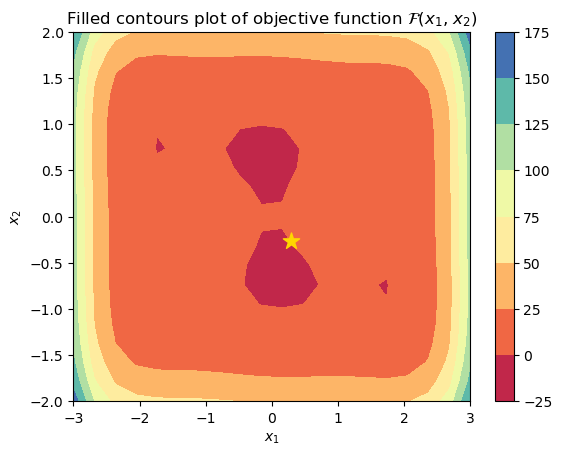

In [2]:
import matplotlib.pyplot as plt
X1 = np.linspace(-3, 3, 20)
X2 = np.linspace(-2, 2, 20)

param_grid = np.array([[x1, x2] for x2 in X2 for x1 in X1])
real_loss = [sample_loss(params) for params in param_grid]

C, G = np.meshgrid(X1, X2)
result = np.array(real_loss).reshape(C.shape)
plt.figure()
cp = plt.contourf(C, G, np.array(real_loss).reshape(C.shape), cmap=plt.cm.Spectral)
plt.colorbar(cp)
plt.scatter(xp[np.argmin(yp)][0], xp[np.argmin(yp)][1], marker='*', c='gold', s=150)
plt.title('Filled contours plot of objective function $\mathcal{F}$($x_{1}$, $x_{2}$)')
plt.xlabel('$x_{1}$')
plt.ylabel('$x_{2}$')
plt.show()